## Market Analysis

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from os import listdir
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from utils.util import get_data, plot_data, compute_daily_returns, fit_scatter, compute_sharpe_ratio, ticks_in_cluster
%matplotlib inline 

### Initializations

In [2]:
date_start = '2016-07-01'
date_end = '2017-07-08'
folder_name = 'download'

dates = pd.date_range(date_start, date_end)

### Load Stock Data

In [3]:
# create list of tickers from filenames 
files_list = listdir(os.path.join(folder_name))
symbols = map(lambda x: x.split('.csv')[0], files_list)

if 'SPY' in symbols: # eliminate SPY from symbols so that it becomes first element processed by get_data
    del symbols[symbols.index('SPY')]

df = get_data(symbols, dates, price='Close', folder=folder_name)

print "Total Stocks:", df.shape[1]

Total Stocks: 493


### Clean DataFrame

In [4]:
# delete all columns that are NaN for the last N days or for more than X% of the time
days = 20
date_temp = df.index[-1] - timedelta(days=20)
df_sub = df.ix[date_temp:date_end]

print "Deleting:"
for name, values in df_sub.iteritems():
    if (df_sub[name].isnull().all()) | (df[name].isnull().sum()/float(df.shape[0]) > 0.35):
        del df[name]
        print name,

print "\nTotal Stocks:", df.shape[1]

Deleting:
ALTR AMT ANR APOL ARG BEAM BMC BRCM BTU CAM CFN COV CSC CVC CVH DELL DTV EMC FDO FTI GAS HAR HCBK HNZ HOT HSP JOY LLTC LO LXK MJN MWV PCL PCP PCS PLL POM SAI SE SIAL SNDK STJ SWY TE TEG TWC 
Total Stocks: 447


### Compute statistics

In [5]:
# normalize all stock prices
df_n = df / df.ix[0]

# Compute cumulative ruturn (from beginning to end)
cum_ret = df_n.ix[-1] - df_n.ix[0]

# Compute daily return, average and standard deviation (volatility)
daily_returns = compute_daily_returns(df)
avg_daily_ret = daily_returns.mean()
std_daily_ret = daily_returns.std()

# Compute sharp ratio
sharpe_ratio = compute_sharpe_ratio(df)

# Group statistics
stat = pd.concat([cum_ret, avg_daily_ret, std_daily_ret, sharpe_ratio], 
          keys=['cum_ret', 'avg_daily_ret', 'std_daily_ret', 'sharpe_ratio'],axis=1)

# Show statistics sorted by sharp ratio
stat = stat.sort_values(['sharpe_ratio'], ascending=False)
stat.head()

,cum_ret,avg_daily_ret,std_daily_ret,sharpe_ratio
BA,0.560413,0.001787,0.009794,2.896869
BAC,0.895420,0.002612,0.014980,2.768455
CMA,0.834644,0.002483,0.014828,2.658478
AMAT,0.822520,0.002461,0.015093,2.588295
MU,1.416000,0.003710,0.022912,2.570402


### Identify and select relevant stocks
Focusing on average daily returns and volatility let's define an elliptical cluster in the area where we want to investigate

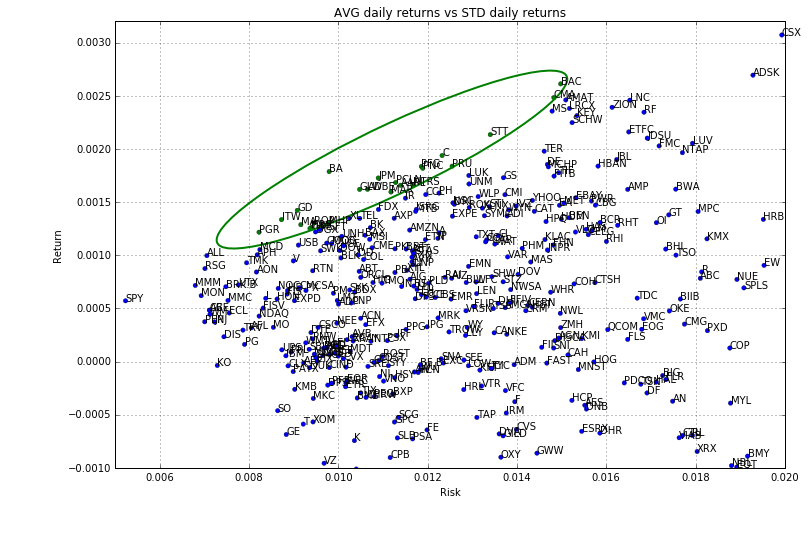

23 stocks selected:
['AAPL', 'ADBE', 'BA', 'BAC', 'C', 'CMA', 'GD', 'GLW', 'HRS', 'ITW', 'JPM', 'MA', 'MAR', 'MHP', 'NTRS', 'PCLN', 'PFG', 'PGR', 'PNC', 'PRU', 'ROP', 'STT', 'TWX']

,cum_ret,avg_daily_ret,std_daily_ret,sharpe_ratio
BA,0.560413,0.001787,0.009794,2.896869
BAC,0.895420,0.002612,0.014980,2.768455
CMA,0.834644,0.002483,0.014828,2.658478
STT,0.687779,0.002135,0.013402,2.528818
JPM,0.531995,0.001726,0.010893,2.515960
C,0.610387,0.001938,0.012324,2.496788
GD,0.423942,0.001422,0.009079,2.486855
PFG,0.570873,0.001836,0.011859,2.457234
GLW,0.492361,0.001620,0.010476,2.454114
ITW,0.393569,0.001335,0.008726,2.428674


In [6]:
fig,ax = plt.subplots(figsize=(12,8))

# define elliptical cluster 
g_ell_center = (0.0112, 0.0019)
g_ell_width = 0.008
g_ell_height = 0.0007
angle = 11.    

g_ellipse = patches.Ellipse(g_ell_center, g_ell_width, g_ell_height, angle=angle, fill=False, edgecolor='green', linewidth=2)
ax.add_patch(g_ellipse)

colors_array = ticks_in_cluster(std_daily_ret, avg_daily_ret,
                                g_ell_center, g_ell_width, g_ell_height, angle)

ax.scatter(std_daily_ret, avg_daily_ret, c=colors_array, linewidths=0.3)

# plot ticker names
tick_all = df.columns.tolist()
for i, txt in enumerate(tick_all):
    ax.annotate(txt, (std_daily_ret[i], avg_daily_ret[i]))

plt.title('AVG daily returns vs STD daily returns')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim((0.005, 0.02))
plt.ylim((-0.001, 0.0032))
plt.grid()
plt.show()

# output stocks in the cluster 
ix = [i for i,val in enumerate(colors_array) if val=='green']
tick_sel = [tick_all[i] for i in ix]
df_sel = df[tick_sel]
print len(ix), "stocks selected:"
print tick_sel,
stat.ix[tick_sel].sort_values(['sharpe_ratio'], ascending=False)

### Perform visual check

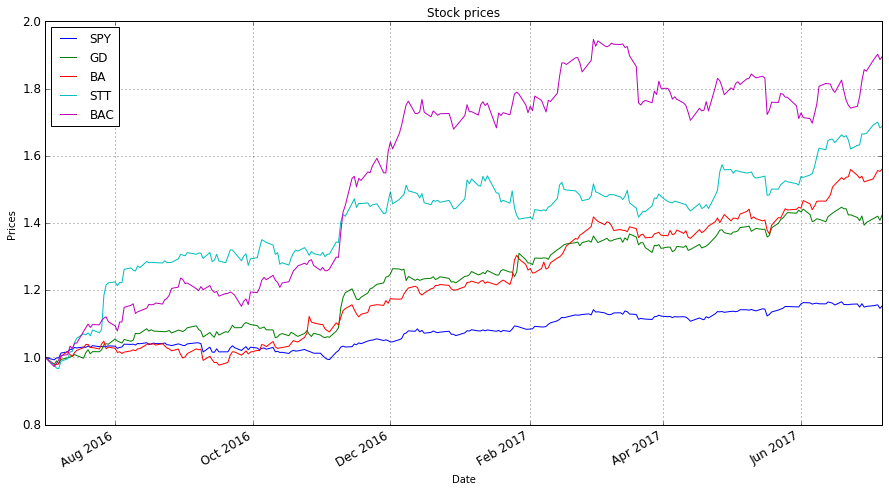

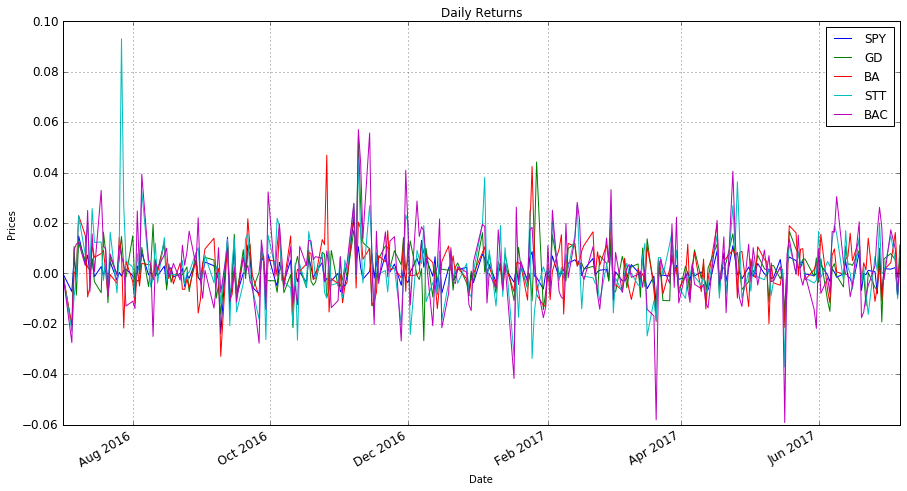

,cum_ret,avg_daily_ret,std_daily_ret,sharpe_ratio
SPY,0.153344,0.000571,0.005231,1.732975
GD,0.423942,0.001422,0.009079,2.486855
BA,0.560413,0.001787,0.009794,2.896869
STT,0.687779,0.002135,0.013402,2.528818
BAC,0.895420,0.002612,0.014980,2.768455


In [7]:
stock = tick_sel
stock = ['SPY','GD','BA','STT','BAC']
plot_data(df_n[stock])
plot_data(daily_returns[stock], title="Daily Returns")
stat.ix[stock]

* **Scatter Plot**

beta= 1.0
alpha= -4.33680868994e-19


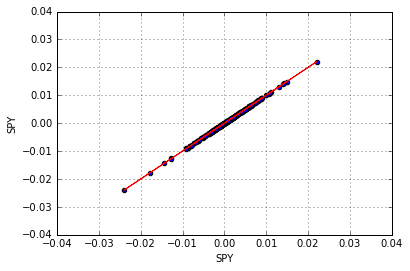

beta= 0.882301406878
alpha= 0.000918454170912


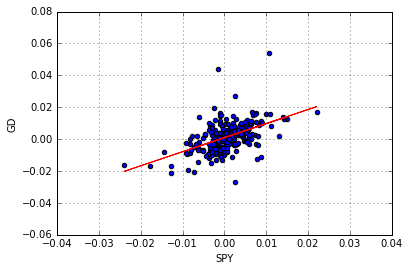

beta= 1.01600555646
alpha= 0.001206961087


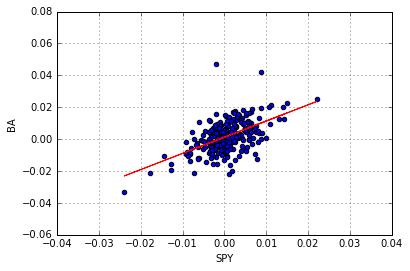

beta= 1.35700589896
alpha= 0.00136005229441


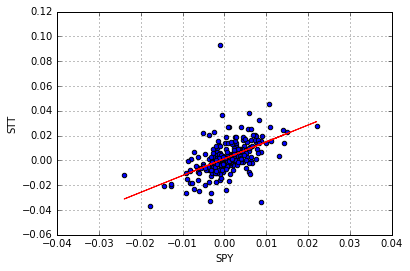

beta= 1.62264627813
alpha= 0.0016857760826


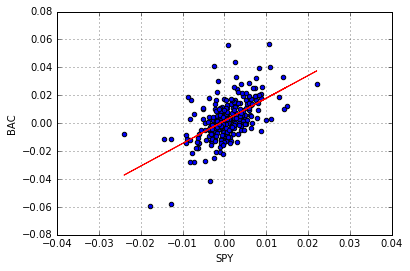

In [8]:
for ticker in stock:
    fit_scatter(daily_returns, x='SPY', y=ticker)

* **Correlation to SPY**

In [9]:
correl = daily_returns.corr(method='pearson')
correl['SPY'][tick_sel].sort_values(ascending=False)

ITW     0.696316
PFG     0.671349
ROP     0.647959
GLW     0.631226
C       0.623914
JPM     0.613296
MA      0.608823
CMA     0.603446
MHP     0.598241
PNC     0.574750
NTRS    0.572711
PRU     0.570386
BAC     0.566654
ADBE    0.564429
BA      0.542698
STT     0.529665
HRS     0.520747
MAR     0.515024
GD      0.508361
PCLN    0.476439
AAPL    0.435686
PGR     0.389141
TWX     0.333542
Name: SPY, dtype: float64